## Imports & constants

In [1]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, 
    TrainingArguments, Trainer, EarlyStoppingCallback, IntervalStrategy
)

from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, MODELS_DIR

[07:28:26|INFO|config.py:58] PyTorch version 2.3.1 available.
[07:28:26|INFO|config.py:105] TensorFlow version 2.16.2 available.
2024-10-08 07:28:27.052557: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 07:28:27.060060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 07:28:27.070886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 07:28:27.070904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register fact

In [2]:
RANDOM_SEED = 123  # random reproducibility
np.random.seed(RANDOM_SEED)
# BASE_CHECKPOINT = "bert-base-uncased"
# BASE_CHECKPOINT = "bert-base-multilingual-cased"
BASE_CHECKPOINT = "camembert/camembert-large"
TASK_NAME = "hasrelation"
TASK_TARGET_COL = "label" # hasrelation?
TASK_INPUT_COL = "input_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}

generated_data_dir_path = os.path.join(INTERIM_DIR, "reduced_text_w_entity_bracket")
assert os.path.exists(generated_data_dir_path)
train_dir = os.path.join(generated_data_dir_path, "train")
test_dir = os.path.join(generated_data_dir_path, "test")

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_reduced_text_w_entity_bracket")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
def get_cat_var_distribution(cat_var: pd.Series) -> pd.DataFrame:
    return pd.concat(
        [cat_var.value_counts(), cat_var.value_counts(normalize=True)], axis=1
    )

## Prepare the datasets for the binary text classification

### Load and process the target

In [36]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

train_df = load_csv(train_dir, index_col=0).assign(**{
        # TASK_INPUT_COL: lambda df: df[["e1_type", "e2_type", "reduced_text"]].apply(lambda row: ' | '.join(row.values.astype(str)), axis=1),
        TASK_INPUT_COL: lambda df: df["reduced_text"],
        TASK_TARGET_COL: lambda df: 2 + ~pd.isnull(df.relations).astype(int),
    },
)
train_df

,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text,input_text,label
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ...","Au milieu de l’[ interview ], un { incendie } ...",0
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ...","Au milieu de l’{ interview }, un [ incendie ] ...",1
2,2576,2,0,CBRN_EVENT,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un incendie est ...","Au milieu de l’[ interview ], un incendie est ...",0
3,2576,0,2,GATHERING,CBRN_EVENT,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un incendie est ...","Au milieu de l’{ interview }, un incendie est ...",1
4,2576,2,1,CBRN_EVENT,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’interview, un [ incendie ] est ...","Au milieu de l’interview, un [ incendie ] est ...",1
...,...,...,...,...,...,...,...,...,...,...
122039,41884,11,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,"Au moment de sortir de la porte du magasin, Mo...","Au moment de sortir de la porte du magasin, Mo...",0
122040,41884,12,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,Au moment de sortir de la { porte } du magasin...,Au moment de sortir de la { porte } du magasin...,0
122041,41884,15,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",NaN,"Depuis la { fenêtre } des toilettes, monsieur ...","Depuis la { fenêtre } des toilettes, monsieur ...",0
122042,41884,17,22,MATERIEL,COLOR,"Le 14 janvier 2014, en pleine Sibérie, dans un...",['HAS_COLOR'],"Depuis la fenêtre des toilettes, monsieur Bace...","Depuis la fenêtre des toilettes, monsieur Bace...",1


In [37]:
train_df.to_csv(os.path.join(INTERIM_DIR, "train-reduced_text_w_entity_bracket.csv"), index=False)

In [ ]:
train_df.to_parquet(os.path.join(INTERIM_DIR, "train-reduced_text_w_entity_bracket.parquet"), index=False)

In [5]:
get_cat_var_distribution(train_df[TASK_TARGET_COL])

,count,proportion
label,,
0,95650,0.783734
1,26394,0.216266


### train-validation split

In [6]:
VALIDATION_RATE = 0.2
train_df, val_df = train_test_split(train_df, test_size=VALIDATION_RATE, shuffle=True, random_state=RANDOM_SEED, stratify=train_df[TASK_TARGET_COL])
train_df.shape, val_df.shape

((97635, 10), (24409, 10))

In [7]:
get_cat_var_distribution(train_df[TASK_TARGET_COL])

,count,proportion
label,,
0,76520,0.783735
1,21115,0.216265


In [8]:
get_cat_var_distribution(val_df[TASK_TARGET_COL])

,count,proportion
label,,
0,19130,0.783727
1,5279,0.216273


### Undersampling the majority class

In [9]:
positive_train_df = train_df.query(f"{TASK_TARGET_COL}==1")
positive_train_df.shape

(21115, 10)

In [10]:
negative_train_df = train_df.query(f"{TASK_TARGET_COL}==0")
negative_train_df.shape

(76520, 10)

In [11]:
# balance classes
train_df = pd.concat([positive_train_df, negative_train_df.sample(positive_train_df.shape[0])], axis=0)
train_df.shape

(42230, 10)

## Create the tokenized datasets for model input

### init the tokenizer

In [12]:
# Hyperparameters
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
task_special_tokens = ["<", ">", "{", "}"] + [
    f"{entity_class}" for entity_class in entity_classes
]
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens, len(tokenizer)

(59, 32063)

### init the train-valid datasets from dataframe

In [13]:
train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds = Dataset.from_pandas(val_df, preserve_index=False)
task_datasets = DatasetDict({"train": train_ds, "validation": val_ds})
task_datasets

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 42230
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 24409
    })
})

In [14]:
task_datasets["train"][0]

{'text_index': 1109,
 'e1_id': 7,
 'e2_id': 2,
 'e1_type': 'CIVILIAN',
 'e2_type': 'PLACE',
 'text': 'Une voiture bleue a percuté un { piéton } à Charly-sur-Marne vendredi soir. D’après les témoins, le conducteur était en état d’ivresse et s’est enfui lorsqu’il a vu la { victime } au sol inerte, sur le [ trottoir ]. La représentante du respect des droits de l’homme, Madame Rodríguez Annie-Christine, a lancé un avis de recherche à la télévision afin de retrouver le conducteur. Des affiches et des tracts ont été distribués dans la ville en plus des annonces diffusées à la radio. En effet, les caméras de surveillance des magasins situés aux alentours de l’accident ont filmé le visage des fugitifs. La { victime } a été transportée à l’hôpital. Son pronostic vital n’est pas engagé.',
 'relations': "['HAS_CONTROL_OVER', 'IS_LOCATED_IN']",
 'reduced_text': 'D’après les témoins, le conducteur était en état d’ivresse et s’est enfui lorsqu’il a vu la { victime } au sol inerte, sur le [ trottoir 

In [15]:
task_datasets["train"][1]

{'text_index': 41177,
 'e1_id': 16,
 'e2_id': 11,
 'e1_type': 'GROUP_OF_INDIVIDUALS',
 'e2_type': 'PLACE',
 'text': 'Un drame est survenu ce matin dans un [ petit village ] du Nigeria. Une école primaire catholique réservée aux jeunes filles a été bombardée par l\'association terroriste "Harmattan arabe". Les écolières étaient en cours d\'histoire au moment de l\'attaque. Les malfrats ont ensuite enlevé les jeunes filles pour les contraindre à porter le voile et à étudier le Coran. Deux personnes ont été tuées suite aux boulets envoyés. Vingt-trois { personnes }, dont Soumiya Duverney, le fondateur de l\'école catholique, ont été blessées. Transportées d\'urgence à l\'hôpital dans de vieilles ambulances, les blessés étaient entre la vie et la mort.',
 'relations': "['IS_LOCATED_IN']",
 'reduced_text': "Un drame est survenu ce matin dans un [ petit village ] du Nigeria. Vingt-trois { personnes }, dont Soumiya Duverney, le fondateur de l'école catholique, ont été blessées.",
 'input_text

### Tokenize the datasets

In [16]:
def tokenize_function(example: dict):
    return tokenizer(example[TASK_INPUT_COL], truncation=True)

# We’re using batched=True in our call to map so the function is applied to multiple elements of our dataset at once, and not on each element separately
# This is way faster
# Source https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# columns are removed because DataCollatorWithPadding doesn't support any other columns than the ones produced by the tokenizer (or non tensors)
tokenized_datasets = task_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/42230 [00:00<?, ? examples/s]

Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 42230
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 24409
    })
})

In [17]:
tokenized_datasets.column_names

{'train': ['text_index',
  'e1_id',
  'e2_id',
  'e1_type',
  'e2_type',
  'text',
  'relations',
  'reduced_text',
  'input_text',
  'label',
  'input_ids',
  'attention_mask'],
 'validation': ['text_index',
  'e1_id',
  'e2_id',
  'e1_type',
  'e2_type',
  'text',
  'relations',
  'reduced_text',
  'input_text',
  'label',
  'input_ids',
  'attention_mask']}

In [18]:
type(tokenized_datasets["train"][1]['attention_mask'])

list

### Token numbers distribution

In [19]:
from typing import Any, Dict

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])


def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example[TASK_INPUT_COL])}


tokenized_datasets = tokenized_datasets.map(count_token_in_dataset_element)
tokenized_datasets

Map:   0%|          | 0/42230 [00:00<?, ? examples/s]

Map:   0%|          | 0/24409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 42230
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 24409
    })
})

In [20]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(tokenized_datasets[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in tokenized_datasets.keys()
    }
)
split2ntokens_df.describe()

validation: 100%|██████████| 24409/24409 [00:01<00:00, 12389.04it/s]


,train,validation
count,42230.000000,24409.000000
mean,61.188894,63.261502
std,30.646281,29.189710
min,11.000000,11.000000
25%,39.000000,42.000000
50%,54.000000,58.000000
75%,76.000000,78.000000
max,299.000000,266.000000


<Axes: >

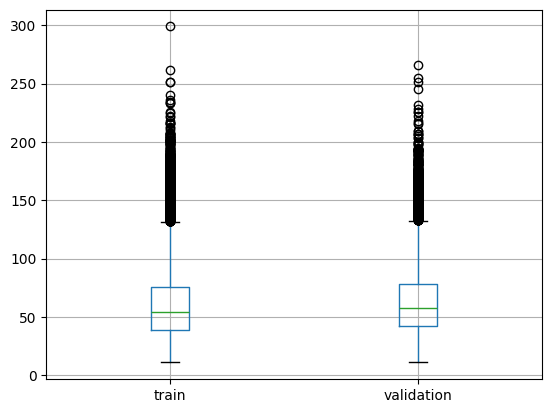

In [21]:
split2ntokens_df.boxplot()

In [22]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] > 200)

Filter:   0%|          | 0/42230 [00:00<?, ? examples/s]

Dataset({
    features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label', 'input_ids', 'attention_mask', 'n_tokens'],
    num_rows: 48
})

In [23]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == 19)[0]['input_text']

Filter:   0%|          | 0/42230 [00:00<?, ? examples/s]

'[ Toutes ] les { personnes présentes } sont ressorties saines et sauves.'

In [25]:
# tokenized_datasets["train"].filter(lambda x: x['n_tokens'] > 300)[0]['input_text']

### Test the batch-level padding with a data collator

In [26]:
samples = tokenized_datasets.remove_columns(task_datasets["train"].column_names)["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[42, 46, 31, 28, 20, 20, 35, 34]

In [27]:
task_datasets

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 42230
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'label'],
        num_rows: 24409
    })
})

In [28]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 46]),
 'attention_mask': torch.Size([8, 46]),
 'n_tokens': torch.Size([8])}

## Fine-tuning a model with the Trainer API

### Compute the weight of classes to handle imbalance

In [29]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
n_examples = train_df.shape[0]
n_classes = train_df[TASK_TARGET_COL].nunique()
def compute_class_weights(lbl_df: pd.DataFrame) -> pd.Series:
    return get_cat_var_distribution(lbl_df[TASK_TARGET_COL]).reset_index(drop=False)["count"].apply(lambda x: (1 / x) * (n_examples / n_classes)).rename("weight")
pd.concat([get_cat_var_distribution(train_df[TASK_TARGET_COL]), compute_class_weights(train_df)], axis=1)

,count,proportion,weight
1,21115,0.5,1.0
0,21115,0.5,1.0


### Init the model

In [30]:
n_classes = train_df[TASK_TARGET_COL].nunique()
print(f"{n_classes=}")
model = AutoModelForSequenceClassification.from_pretrained(BASE_CHECKPOINT, num_labels=n_classes)
model.resize_token_embeddings(len(tokenizer))

n_classes=2


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(32063, 1024, padding_idx=1)

In [31]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32063, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-23): 24 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=1024, out_feature

### Init the trainer

Source: https://stackoverflow.com/questions/69087044/early-stopping-in-bert-trainer-instances#69087153

1. Use `load_best_model_at_end = True` (EarlyStoppingCallback() requires this to be True).
2. `evaluation_strategy = 'steps'` or IntervalStrategy.STEPS instead of 'epoch'.
3. `eval_steps = 50` (evaluate the metrics after N steps).
4. `metric_for_best_model = 'f1'`

In [34]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir=os.path.join(MODELS_DIR, f"{TASK_NAME}-byTrainerAPI-checkpoints"),
    per_device_train_batch_size=20,    
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    evaluation_strategy=IntervalStrategy.EPOCH, # steps
    # eval_steps = 50, # Evaluation and Save happens every 50 steps
    learning_rate=2e-5,
    weight_decay=0.01,
    save_strategy=IntervalStrategy.EPOCH,
    logging_dir=os.path.join(MODELS_DIR, f"{TASK_NAME}-byTrainerAPI-tensorboard"),
    save_total_limit = 2, # Only last 2 models are saved. Older ones are deleted
    push_to_hub=False,
    metric_for_best_model = 'eval_loss',
    greater_is_better=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Launch the training

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.330900,0.294774,0.874145,0.809645,0.876846,0.833775


KeyboardInterrupt: 

## Evaluate

TODO...

In [ ]:
# After training, access the path of the best checkpoint like this
best_ckpt_path = trainer.state.best_model_checkpoint
best_ckpt_path

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model=best_ckpt_path, device="cuda")

In [ ]:
classifier(val_ds["input_text"][:10])

In [ ]:
val_df.iloc[:10][["input_text", "label", "relations"]]

In [ ]:
val_ds["input_text"][5]

In [ ]:
classifier(val_ds["text"][5])

In [ ]:
val_df[TASK_TARGET_COL].iloc[:10]

In [ ]:
val_ds["input_text"]

In [ ]:
val_ds[0]

In [ ]:
print(samples['input_ids'][2])

In [ ]:
tokenizer.decode(samples['input_ids'][0])

In [ ]:
tokenizer.decode(samples['input_ids'][1])

In [ ]:
tokenizer.decode(samples['input_ids'][2])